# Feature engineering
## Setup

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

from own_functions import train_test_timesplit

In [2]:
pd.options.display.max_columns = None

In [3]:
# part of this maybe can be dropped 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error

In [4]:
# Load data
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = data_subsets_splitted_joined

In [6]:
# get another set of dataset with monthly fequency (number of cases per month = SUM)
#sj_train_train_month = sj_train_train[['total_cases']].resample('M').sum()
#iq_train_train_month = iq_train_train[['total_cases']].resample('M').sum()
#sj_train_test_month = sj_train_test[['total_cases']].resample('M').sum()
#iq_train_test_month = iq_train_test[['total_cases']].resample('M').sum()

---

## Feature engineering - Functions
Subset dataframe to have a smaller for testing the functions created

### Function to create a dataframe with lagged/shifted features
First function for continous lags from zero to max_lag:

In [7]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 1.
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(1, max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

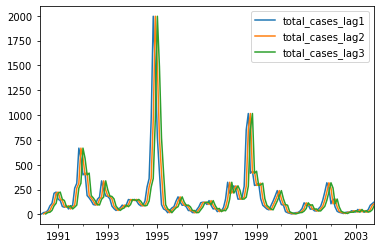

In [8]:
# testing the function
test = get_lagged_dataframe(df=sj_train_train_month, features=['total_cases'], max_lag=3).plot();

Second function for specific lags (non-continous)

In [9]:
def get_specific_lagged_dataframe(df, features, lags):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags given in lags start at 0, which is the original feature (without shift).
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    lags: list, which contains lags (int), zero for original data will be added in the function
    
    """
    d = {}
    lags.append(0)
    for feature in features:
        for lag in lags:
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

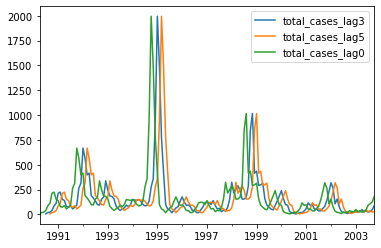

In [10]:
# test the function
get_specific_lagged_dataframe(df=sj_train_train_month, features=['total_cases'], lags=[3,5]).plot();

### Granger Causality
The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another (from [Wikipedia: Granger causality](https://en.wikipedia.org/wiki/Granger_causality))

From [doc](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html): The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests

In [12]:
# raw output of grangercausalitytests
test_result = grangercausalitytests(sj_train_train[['total_cases','reanalysis_specific_humidity_g_per_kg']], maxlag=5, verbose=False)
test_result

{1: ({'ssr_ftest': (9.475614384969624, 0.002163660805263604, 699.0, 1),
   'ssr_chi2test': (9.516282257866491, 0.0020365675077560724, 1),
   'lrtest': (9.452358152031593, 0.0021087780588431825, 1),
   'params_ftest': (9.475614384969566, 0.002163660805263604, 699.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.306106080445232, 0.01384706143419516, 696.0, 2),
   'ssr_chi2test': (8.674081501126746, 0.013075163679990693, 2),
   'lrtest': (8.620854166704703, 0.013427813573817221, 2),
   'params_ftest': (4.3061060804451605, 0.013847061434196341, 696.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.7360570613200177, 0.042706190469642295, 693.0, 3),
   'ssr_chi2test': (8.291082004000055, 0.0403638057321311, 3),
   'lrtest': (8.24236485268375, 0.04125952198219542, 3),
   'params_ftest': (2.7360570613200608, 0.04270619046963683, 693.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

Because the output of the `grangercausalitytests` of statsmodels is a little bit unhandy, we write a function to extract the p-values from the raw-results.

In [13]:
def get_p_values_grangercausalitytests(df, target, maxlag, test='ssr_chi2test'):
    """
    Check Granger Causality of all possible combinations of the target variable/time series 
    with the other variables/time series in the dataframe. 
    
    grangercausalitytests:
    Test whether the time series in the second column Granger causes the time series in the first column. 
    
    ----------
    Parameters
    
    df: dataframe, which contains variables (also target) as columns and with time as index 
    target: str, of target variable name
    maxlag: int, number of lags
    test: str, of test used by grangercausalitytests
        tests used in grangercausalitytests: 'ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'
        
        params_ftest, ssr_ftest are based on F distribution
        ssr_chi2test, lrtest are based on chi-square distribution
    """
    df = df.select_dtypes(include='number')
    variables = df.columns.tolist()
    variables.remove(target)
    d = {}
    for var in variables:
        test_result = grangercausalitytests(df[[target, var]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        d[f'{var}'] = p_values
    output_df = pd.DataFrame.from_dict(d)
    output_df.index = [f'lag_{lag}' for lag in range(1, maxlag+1)]
    return output_df
# for statistics

In [14]:
# test the function
get_p_values_grangercausalitytests(df=iq_train_train, target='total_cases', maxlag=15, test='ssr_chi2test')

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_k,station_max_temp_c,station_min_temp_c,station_precip_mm,month,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,population
lag_1,0.9686,0.4186,0.4263,0.3603,0.1921,0.2715,0.8857,0.4814,0.8409,0.0796,0.9336,0.4040,0.5733,0.6081,0.1684,0.5818,0.7707,0.2543,0.3170,0.0885,0.5463,0.3064,0.9603
lag_2,0.0089,0.0597,0.4657,0.4413,0.3800,0.4075,0.6962,0.7053,0.2367,0.1512,0.6702,0.6091,0.5288,0.7500,0.2811,0.5519,0.0085,0.4440,0.4761,0.1748,0.7511,0.1132,0.0106
lag_3,0.0664,0.1614,0.7913,0.5912,0.5145,0.8313,0.8726,0.9374,0.2332,0.6129,0.6888,0.8937,0.6389,0.4619,0.7503,0.1885,0.0614,0.5066,0.5174,0.6404,0.4992,0.2911,0.0765
lag_4,0.1372,0.0362,0.0747,0.1466,0.1008,0.0968,0.8738,0.8254,0.3617,0.5244,0.7368,0.7615,0.5101,0.5612,0.8738,0.2996,0.0401,0.6580,0.6426,0.5824,0.5871,0.5303,0.1585
lag_5,0.1808,0.0246,0.1105,0.1577,0.1245,0.1327,0.8919,0.9171,0.2748,0.4828,0.3282,0.8459,0.4808,0.6321,0.8924,0.3923,0.0790,0.3769,0.1627,0.5557,0.0601,0.6014,0.2063
lag_6,0.1394,0.0324,0.1772,0.2392,0.1409,0.1991,0.7846,0.8982,0.3601,0.4070,0.1711,0.8999,0.6059,0.7249,0.9420,0.2167,0.0711,0.4907,0.2328,0.4801,0.0823,0.5100,0.1615
lag_7,0.1990,0.0577,0.2809,0.2325,0.1378,0.2920,0.8669,0.9434,0.1448,0.4943,0.2528,0.9182,0.5449,0.8194,0.8703,0.2498,0.1076,0.5437,0.2858,0.5720,0.1345,0.6451,0.2271
lag_8,0.2829,0.1000,0.3961,0.3332,0.1455,0.4026,0.8712,0.9583,0.1842,0.5236,0.2944,0.9139,0.6688,0.8006,0.8577,0.2584,0.1348,0.5142,0.3443,0.6062,0.2250,0.7744,0.3164
lag_9,0.3647,0.0959,0.4825,0.3980,0.1740,0.5191,0.9121,0.7111,0.2024,0.5174,0.2767,0.9342,0.4326,0.8210,0.9016,0.1443,0.1649,0.4401,0.2832,0.5797,0.2281,0.8151,0.4013
lag_10,0.4868,0.1504,0.4269,0.1056,0.1376,0.4424,0.8783,0.7740,0.2689,0.5522,0.2026,0.9599,0.3244,0.8941,0.3700,0.2238,0.2249,0.5682,0.3829,0.6152,0.1784,0.7678,0.5247


#### other function 
Function [from example for VAR models](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/). 
Gives p-values of all possible combinations of variables in the time series. But only gives one (the min p-value) over all lags and not identify the lag.

In [15]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [16]:
# grangercausalitytests can not handle object features - subset df
df_train = sj_train_train[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
                     'station_min_temp_c', 'reanalysis_air_temp_c', 'reanalysis_avg_temp_c', 
                     'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c']]

maxlag=12
grangers_causation_matrix(df_train, df_train.columns)

,total_cases_x,reanalysis_specific_humidity_g_per_kg_x,station_avg_temp_c_x,station_min_temp_c_x,reanalysis_air_temp_c_x,reanalysis_avg_temp_c_x,reanalysis_dew_point_temp_c_x,reanalysis_max_air_temp_c_x
total_cases_y,1.0000,0.002,0.0001,0.000,0.0009,0.0011,0.0020,0.0033
reanalysis_specific_humidity_g_per_kg_y,0.0208,1.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
station_avg_temp_c_y,0.0026,0.000,1.0000,0.001,0.0002,0.0009,0.0001,0.0000
station_min_temp_c_y,0.0065,0.000,0.0000,1.000,0.0000,0.0000,0.0000,0.0000
reanalysis_air_temp_c_y,0.0002,0.000,0.0000,0.000,1.0000,0.0002,0.0000,0.0003
reanalysis_avg_temp_c_y,0.0004,0.000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000
reanalysis_dew_point_temp_c_y,0.0223,0.000,0.0000,0.000,0.0000,0.0000,1.0000,0.0000
reanalysis_max_air_temp_c_y,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,1.0000


---
## Granger Causality Chain
Functions to automatically get p_values (as dataframe with actual values and as a list of features and lags below a p-value threshold). These can then be used to generate a dataframe of only those features-lag combinations (defined in previous step).

In [30]:
def p_values_grangercausalitytests(df, target, maxlag, test='ssr_chi2test', p_level=0.05):
    """
    Check Granger Causality of all possible combinations of the target variable/time series 
    with the other variables/time series in the dataframe. 
    
    grangercausalitytests:
    Test whether the time series in the second column Granger causes the time series in the first column. 
    
    ----------
    Parameters
    
    df: dataframe, which contains variables (also target) as columns and with time as index 
    target: str, of target variable name
    maxlag: int, number of lags
    test: str, of test used by grangercausalitytests
        tests used in grangercausalitytests: 'ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'
        
        params_ftest, ssr_ftest are based on F distribution
        ssr_chi2test, lrtest are based on chi-square distribution
    p_level: float, gives p-value threshold which selects if a feature will be included in features_lag
    
    ----------
    Returns 
    
    p_values_df: dataframe, with p-values of all feature - lag combinations
    features_lag: list, which contains again lists with combinations of features and respective
                    lags which achieved a p-value below p_level.
    """
    df = df.select_dtypes(include='number')
    variables = df.columns.tolist()
    variables.remove(target)
    d={}
    features_lag=[]
    for var in variables:
        test_result = grangercausalitytests(df[[target, var]], maxlag=maxlag, verbose=False)
        p_values=[]
        for i in range(maxlag):
            p = round(test_result[i+1][0][test][1],4)
            p_values.append(p)
            if p < p_level:
                features_lag.append([var, i])
        d[f'{var}'] = p_values
    p_values_df = pd.DataFrame.from_dict(d)
    p_values_df.index = [f'lag_{lag}' for lag in range(1, maxlag+1)]
    return p_values_df, features_lag

In [ ]:
def build_lagged_dataframe(df, features_lag):
    """
    Creates new dataframe with certain lagged and non-lagged features as columns. 
    Features and lags are given by a list, which contains lists with respective
    feature and lag combination.
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features_lag: list, which contains again lists with combinations of 
                    features and respective lags
    
    ----------
    Returns 
    
    lagged_df: dataframe, which only contains features and lagged features defined by 
                features_lag
    """
    d = {}
    for i in features_lag:
        feature, lag = i
        shifted_feature = []
        for r in range(len(df)):
            shifted_feature.append(df.shift(lag)[feature][r])
            if lag == 0:
                d[f'{feature}'] = shifted_feature
            else:
                d[f'{feature}_lag{lag}'] = shifted_feature
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    return lagged_df

In [ ]:
# execute p_values_grangercausalitytests for SJ and IQ train_train
p_values_df_sj_train_train, features_lag_sj_train_train = p_values_grangercausalitytests(sj_train_train, 'total_cases', 12)
p_values_df_iq_train_train, features_lag_iq_train_train = p_values_grangercausalitytests(iq_train_train, 'total_cases', 12)

Generate the lagged dataframes of certain feature - lag combinations. 
**Important:** Only use the features_lag list of the train_train data and do not generate a new list on the train_test set. If not, both sets could contain different features or different numbers of features. Furthermore, it could lead to data leakage.

In [ ]:
# execute build_lagged_dataframe for SJ and IQ on train_train
gc_lagged_sj_train_train = build_lagged_dataframe(sj_train_train, features_lag_sj_train_train)
gc_lagged_iq_train_train = build_lagged_dataframe(iq_train_train, features_lag_iq_train_train)

# execute build_lagged_dataframe for SJ and IQ on train_test
# use features_lag_sj_train_train list on test data to prevent different features and data leakage
gc_lagged_sj_train_test = build_lagged_dataframe(sj_train_test, features_lag_sj_train_train)
gc_lagged_iq_train_test = build_lagged_dataframe(iq_train_test, features_lag_iq_train_train)

In [ ]:
# add total_cases again to the gc_lagged datframes
gc_lagged_sj_train_train = gc_lagged_sj_train_train.join(sj_train_train['total_cases'])
gc_lagged_sj_train_test = gc_lagged_sj_train_test.join(sj_train_test['total_cases'])
gc_lagged_iq_train_train = gc_lagged_iq_train_train.join(iq_train_train['total_cases'])
gc_lagged_iq_train_test = gc_lagged_iq_train_test.join(iq_train_test['total_cases'])

In [ ]:
data_subsets_splitted_joined_gc = [gc_lagged_sj_train_train, gc_lagged_sj_train_test, gc_lagged_iq_train_train, gc_lagged_iq_train_test]

In [ ]:
# save the gc_lagged data subsets in a pickle
pickle.dump(data_subsets_splitted_joined_gc, open('gc_lagged_data.pickle', 'wb'))

---
## Features based on temperature functions 
The vital rates of mosquitos (main vector of dengue: Ae. aegypti) respond strongly and nonlinearly to temperature and therefore to climate change. We extracted the temperature dependent fuctions from the paper *"Thermal biology of mosquito-borne disease"* ([Mordecai et al. 2019](https://onlinelibrary.wiley.com/doi/full/10.1111/ele.13335)). All selected functions describe the temperature dependency of the main dengue vector *Ae. aegypti* (in context with dengue transmission).
* `biting_rate` for the biting rate
* `fecundity` for fecundity (measured as eggs per female per day)
* `mdr`for mosquito development rate (MDR)
* `immature_survival`for survival of immature stages (eggs, larvae and pupae)
* `lifespan` for mosquito lifespan 
* `transmission_probability` for the probability of transmission
* `infection_probability` for the probability of infection
* `pdr`for parasite development rate (PDR)

### Set up all the small functions

In [17]:
# briere function: q*T*[T-Tmin]*[Tmax-T]^(1/2)
def briere_function(q, T, Tmin, Tmax):
    return (q*T*(T-Tmin)*(Tmax-T)**(1/2))

# quadratic function: -q*[T-Tmin]*[T-Tmax]^(1/2)
def quadratic_function(q, T, Tmin, Tmax):
    return (-q*(T-Tmin)*(T-Tmax))

In [18]:
# biting rate
def biting_rate(T):
    return briere_function(q=(2.02*(10**(-4))), T=T, Tmin=13.8, Tmax=40.0)

# fecundity
def fecundity(T):
    return briere_function(q=(8.16*(10**(-3))), T=T, Tmin=14.7, Tmax=34.4)

# Mosquito Dev. Rate (MDR)
def mdr(T):
    return briere_function(q=(7.83*(10**(-5))), T=T, Tmin=11.6, Tmax=39.1)

# immature_survival
def immature_survival(T):
    return quadratic_function(q=(5.99*(10**(-3))), T=T, Tmin=13.6, Tmax=38.3)

# lifespan
def lifespan(T):
    return quadratic_function(q=(1.44*(10**(-1))), T=T, Tmin=9, Tmax=37.7)

# transmission probability (A. aegypti)
def transmission_probability(T):
    return briere_function(q=(8.33*(10**(-4))), T=T, Tmin=17.2, Tmax=35.8)

# infection probability (A. aegypti)
def infection_probability(T):
    return briere_function(q=(4.88*(10**(-4))), T=T, Tmin=12.7, Tmax=37.4)

# Mosquito Dev. Rate (MDR) 
def pdr(T):
    return briere_function(q=(6.13*(10**(-5))), T=T, Tmin=10.3, Tmax=45.6)

In [19]:
def get_temperature_features(data_set, t_feat='reanalysis_air_temp_c'):
    """
    Applies the different functions of a temperature variable on each dataframe in a dataset.
    
    ----------
    Parameters
    
    data_set: list of dataframe
    t_feat: string, column name of a temperature variable, the temperature functions should be applied on 
    """
    for i in range(len(data_set)):
        data_set[i] = (
            data_set[i]
            .assign(biting_rate = lambda x: biting_rate(x[t_feat]))
            .assign(fecundity = lambda x: fecundity(x[t_feat]))
            .assign(mdr = lambda x: mdr(x[t_feat]))
            .assign(immature_survival = lambda x: immature_survival(x[t_feat]))
            .assign(lifespan = lambda x: lifespan(x[t_feat]))
            .assign(transmission_probability = lambda x: transmission_probability(x[t_feat]))
            .assign(infection_probability = lambda x: infection_probability(x[t_feat]))
            .assign(pdr = lambda x: pdr(x[t_feat])) 
        )
    return data_set

In [20]:
# apply function on data_subsets_splitted_joined to get temperature variables 
data_subsets_feat = get_temperature_features(data_subsets_splitted_joined)

---
## Get cumulative precipitation variable
Get a variables which describe the cumulative precipitation within the last two to six weeks. 
* `cum_precip_2w` for cumulative precipitation within the last two weeks
* `cum_precip_3w` for cumulative precipitation within the last three weeks.
* `cum_precip_4w` for cumulative precipitation within the last four weeks.
* `cum_precip_5w` for cumulative precipitation within the last five weeks.
* `cum_precip_6w` for cumulative precipitation within the last six weeks.

In [21]:
def get_cumulative_precip(data_set, precip_feat='station_precip_mm'):
    """
    Applies the different functions to get the cumulative precipitation for certain phases on each dataframe in a dataset.
    
    ----------
    Parameters
    
    data_set: list of dataframe
    precip_feat: string, column name of a precipitation variable, 
            the cumulative precipitation values should be based on 
    """
    for i in range(len(data_set)):
        data_set[i] = (
            data_set[i]
            .assign(cum_precip_2w = lambda x: x[precip_feat].rolling(2).sum())
            .assign(cum_precip_3w = lambda x: x[precip_feat].rolling(3).sum())
            .assign(cum_precip_4w = lambda x: x[precip_feat].rolling(4).sum())
            .assign(cum_precip_5w = lambda x: x[precip_feat].rolling(5).sum())
            .assign(cum_precip_6w = lambda x: x[precip_feat].rolling(6).sum())
        )
    return data_set

In [22]:
# apply function on data_subsets_splitted_joined to get temperature variables 
data_subsets_feat = get_cumulative_precip(data_subsets_feat)

## Save feature engineered data subsets

In [23]:
# save the gc_lagged data subsets in a pickle
pickle.dump(data_subsets_feat, open('data_subsets_features.pickle', 'wb'))

In [ ]:
# FOR LOADING
#data_subsets_features = pickle.load(open('data_subsets_features.pickle', 'rb'))

#sj_train_train_feat, \
#sj_train_test_feat, \
#iq_train_train_feat, \
#iq_train_test_feat = data_subsets_features

---
# Adding lagged values
For predictive modeling the previous values (lagged by a certain time interval) of certain variables are needed.

--> Function for `get_lagged_datafram()` above, maybe here if not needed above?

In [24]:
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [25]:
# apply get_lagged_dataframe on sj data
sj_train_train_lagged = get_lagged_dataframe(sj_train_train, env_cols(sj_train_train), 8)
sj_train_test_lagged = get_lagged_dataframe(sj_train_test, env_cols(sj_train_test), 8)

In [26]:
# apply get_lagged_dataframe on iq data
iq_train_train_lagged = get_lagged_dataframe(iq_train_train, env_cols(iq_train_train), 8)
iq_train_test_lagged = get_lagged_dataframe(iq_train_test, env_cols(iq_train_test), 8)

In [27]:
# join original dataframe with lagged dataframe
sj_train_train_lags = sj_train_train.join(sj_train_train_lagged)
sj_train_test_lags = sj_train_test.join(sj_train_test_lagged)
iq_train_train_lags = iq_train_train.join(iq_train_train_lagged)
iq_train_test_lags = iq_train_test.join(iq_train_test_lagged)

In [28]:
data_subsets_w_lags = [sj_train_train_lags, sj_train_test_lags, iq_train_train_lags, iq_train_test_lags]
# save the data subsets in a pickle
pickle.dump(data_subsets_w_lags, open('train_w_lags.pickle', 'wb'))